In [48]:
import numpy as np 
import pandas as pd 
import statistics
import os 
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import math 

In [49]:
data_dir = 'sensitivity_20240922'

In [50]:
fund_char = ['flow', 'aum', 'dividend_yield', 'exp_ratio_net', 'fee_rate',
                       'turnover_ratio']
fund_char_mom = ['st_reversal', 'st_momentum', 'momentum', 'int_momentum', 'lt_momentum', 'lt_reversal',
                       'age', 'R_squared', 'fund_st_reversal', 'fund_st_momentum', 'fund_momentum']
fund_family =['family_flow', 'family_aum', 'family_age', 'family_fund_momentum', 'no_funds']

macro_char = ['CFNAI', 'SENT', 'long_term_issuance', 'high_yield_issuance', 'inflation', 'expected_inflation_level', 'expected_inflation_slope', 'gz_spread', 'avg_mat', 'debt/gdp']

holdings_char = ['maturity', 'coupon',
                 'hhi',
                 'gov_share',
                 'abs_share',
                 'corp_share',
                 'muni_share',
                 'cash_share',
                 'rule144a_share',
                 'shortterm_share',
                 'eur_share',
                 'zerocoupon_share',]
syn_char_variables = ['syn_fund_st_reversal_ABS',
                          'syn_fund_st_momentum_ABS',
                          'syn_fund_momentum_ABS',
                          'syn_fund_st_reversal_Cash',
                          'syn_fund_st_momentum_Cash',
                          'syn_fund_momentum_Cash',
                          'syn_fund_st_reversal_Corp',
                          'syn_fund_st_momentum_Corp',
                          'syn_fund_momentum_Corp',
                          'syn_fund_st_reversal_Gov',
                          'syn_fund_st_momentum_Gov',
                          'syn_fund_momentum_Gov',
                          'syn_fund_st_reversal_Muni',
                          'syn_fund_st_momentum_Muni',
                          'syn_fund_momentum_Muni',
                          'syn_fund_st_reversal_Non-bond',
                          'syn_fund_st_momentum_Non-bond',
                          'syn_fund_momentum_Non-bond',
                          'syn_fund_st_reversal_Unknown',
                          'syn_fund_st_momentum_Unknown',
                          'syn_fund_momentum_Unknown']
groups = [fund_char, fund_char_mom, fund_family, macro_char, holdings_char, syn_char_variables]
group_names = ['fund_char', 'fund_char_mom', 'fund_family', 'macro_char', 'holdings_char', 'syn_char_variables']
features =  [f for g in groups for f in g]

In [51]:
def get_normalized_sensitivity(features, df):
    '''filter features and normalilze sensitivity
    '''
    #normalize by total sens 
    #sensitivity_sum = df['0'].sum()
    #normalize by group
    sensitivities = []
    normalized_sensitivities = []
    for i in range(len(features)):
        feature = features[i]
        row = df[df['Unnamed: 0']==feature]
        if not row.empty:
            sens = row['0'].values[0]
            sensitivities.append(sens)
            #normalized_sensitivities.append(sens/sensitivity_sum)
        else: 
            raise ValueError(f'feauture not found: {feature}')
    sensitivity_sum = np.sum(sensitivities)
    for i in range(len(features)):
        normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
    features_df =  pd.DataFrame({
        "features": features,
        "sensitivity_normalized": normalized_sensitivities
    })
    #check sensitivity sum
    #print('features sum', features_df['sensitivity_normalized'].sum())
    return features_df
import pandas as pd

def aggregate_group_sensitivities(df, feature_groups, group_names, features_col='features', sens_col='sensitivity_normalized'):
    """
    Aggregates the normalized sensitivity values for features within each group.
    - df (pd.DataFrame): A DataFrame with columns "features" and "sensitivity_normalized".
    - feature_groups (list of lists): A list of lists where each list contains feature names in a group.
    - group_names (list): A list of group names corresponding to the feature groups.
    Returns a DataFrame with columns "group_name" and "grouped_sensitivity", representing the aggregated sensitivities for each group.
    """
    feature_to_group = {}
    for group_name, features in zip(group_names, feature_groups):
        for feature in features:
            feature_to_group[feature] = group_name
    df['group_name'] = df[features_col].map(feature_to_group)
    grouped_df = (
        df.groupby('group_name', as_index=False)[sens_col].sum()
    )
    #check sensitivity sum
    #print(grouped_df['sensitivity_normalized'].sum())
    return grouped_df

def plot_box_chart(features, medians, lower_percentiles, upper_percentiles, targets=None, order = None, title='', save=False, colors = None):
        if not order:
            order = np.argsort(medians)[::-1]
        features = [features[i] for i in order] 
        medians = [medians[i]*100 for i in order] 
        lower_percentiles = [lower_percentiles[i]*100 for i in order] 
        upper_percentiles = [upper_percentiles[i]*100 for i in order] 
        lower_errors = [mean - lower for mean, lower in zip(medians, lower_percentiles)]
        upper_errors = [upper - mean for mean, upper in zip(medians, upper_percentiles)]
        plt.figure(figsize=(15,15))
        if colors: 
            bar_plot = plt.barh(features, medians, xerr=[lower_errors, upper_errors], capsize=5, color=colors)
        else:
            bar_plot = plt.barh(features, medians, xerr=[lower_errors, upper_errors], capsize=5)
        if targets: 
            for i, bar in enumerate(bar_plot):
                plt.scatter(targets[i], bar.get_y() + bar.get_height()/2, color='red', marker='o', zorder=5)
        plt.xlabel('Sensitivity')
        plt.title('Sensitivity Box Chart '+title)
        plt.gca().invert_yaxis()
        if save:
            plt.savefig("individual_variable_box_chart{}.png".format(title), dpi=300, bbox_inches='tight')
        plt.show()
def plot_sensitivity_with_boostrap(M, N, features, dirname='sensitivity_bond/', normalize=True, graph=True):
    #read all files
    files = os.listdir(dirname)
    files = [_ for _ in files if "sensitivity_" in _]
    df_main = pd.DataFrame()
    name_dict = {}
    invalid_num =0 
    #get all sensitivity numbers
    for file_ind in tqdm(range(len(files))):
        file = files[file_ind]
        df_temp = pd.read_csv(dirname + file)
        if features is None:
            features = df_temp['Unnamed: 0'].unique()
        if normalize:
            df = get_normalized_sensitivity(features, df_temp)
            df = aggregate_group_sensitivities(df, groups, group_names)
            if df.isna().any().any():
                invalid_num += 1
                continue
            df.set_index('group_name', inplace=True)
        else:
            df = df_temp.loc[df_temp['Unnamed: 0'].isin(features)][['Unnamed: 0', '0']]
            df = aggregate_group_sensitivities(df, groups, group_names, features_col='Unnamed: 0', sens_col='0')
            df.set_index('group_name', inplace=True)
        df.columns = [file_ind]
        name_dict[file_ind] = file
        df_main = pd.concat([df_main, df], axis=1)
    df_array = df_main.to_numpy()
    #boostrap process
    inds = np.random.choice(range(len(files)-invalid_num), size=(M, N))
    vals = np.mean(df_array[:, inds], axis=1) #take mean across M models
    p75 = np.percentile(vals, 75, axis=1) 
    p25 = np.percentile(vals, 25, axis=1) 
    median = np.median(vals, axis=1) 
    if graph:
        plot_box_chart(group_names, median, p25, p75, title=f'N{N}M{M}')
    ########
    num = (p75 - p25 )/median
    ########
    return name_dict, num

  5%|▌         | 71/1356 [00:00<00:09, 137.65it/s]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_18931/4264708554.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
 16%|█▌        | 211/1356 [00:01<00:08, 137.26it/s]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_18931/4264708554.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
 29%|██▉       | 391/1356 [00:02<00:06, 144.42it/s]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_18931/4264708554.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivities.append(sensitivities[i]/sensitivity_sum)
 30%|██▉       | 406/1356 [00:02<00:06, 144.64it/s]/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_18931/4264708554.py:20: RuntimeWarning: invalid value encountered in scalar divide
  normalized_sensitivitie

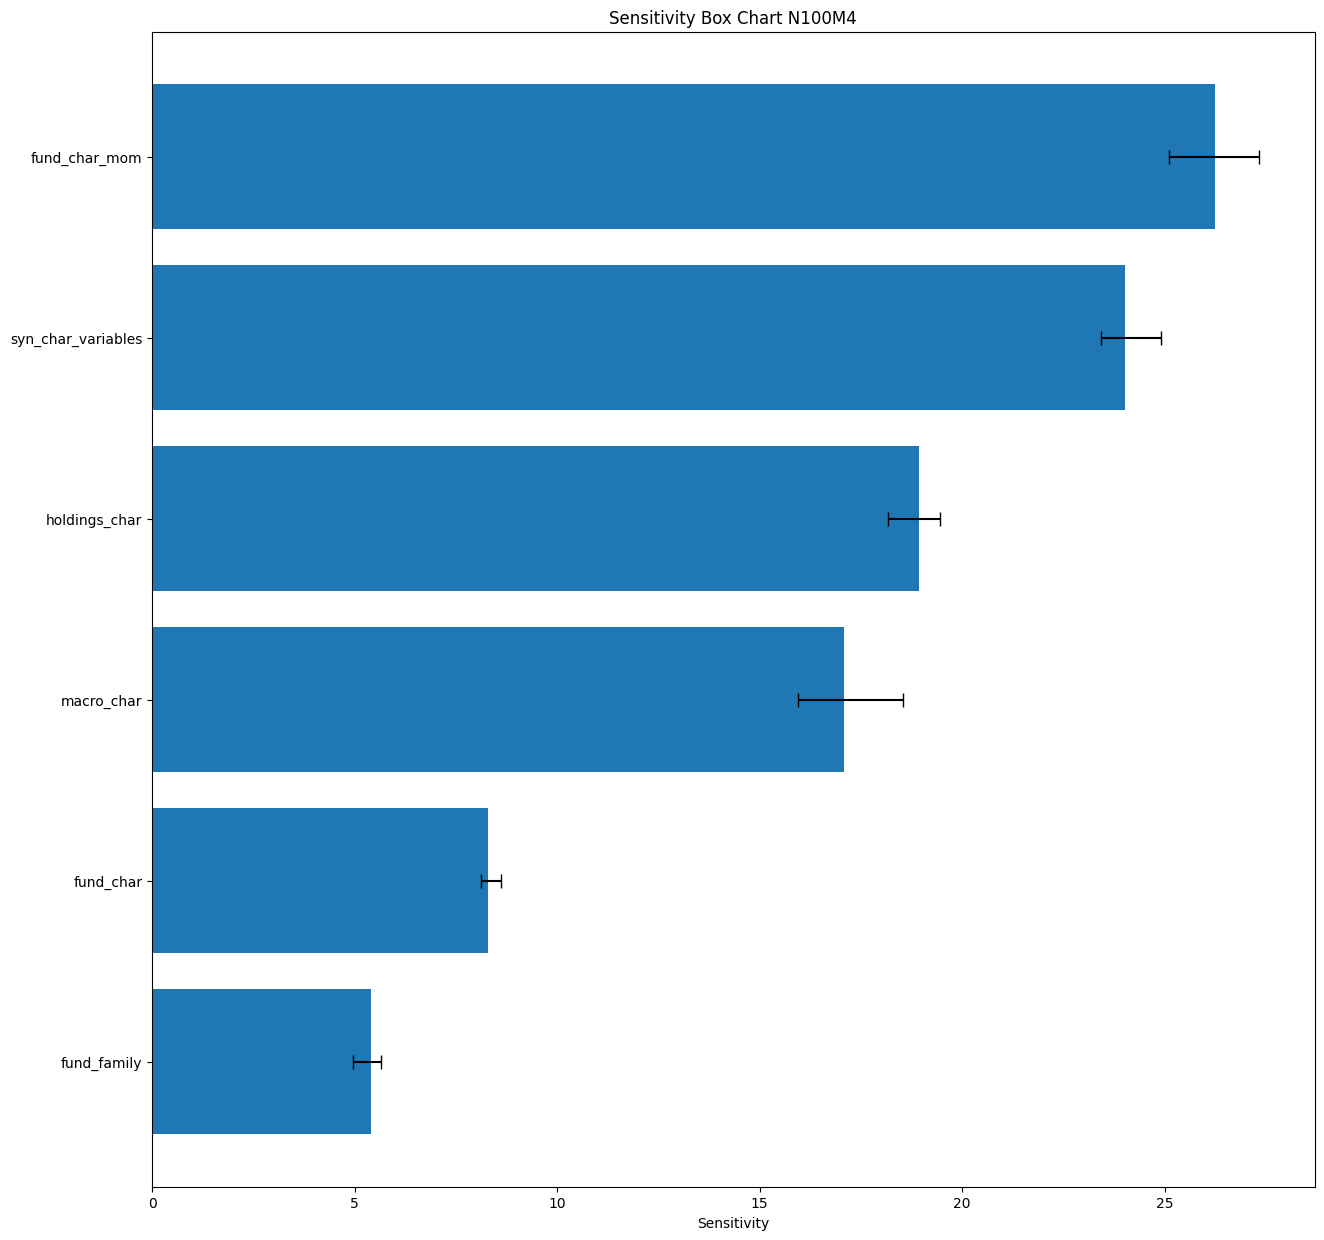

plot done


In [52]:
plot_sensitivity_with_boostrap(M=4, N=100, features=features, dirname=data_dir+'/', normalize = True)
print('plot done')